In [14]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict

In [15]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)


In [11]:
pathout = '/data/kanferg/Sptial_Omics/projects/NguyenLab/spatialomicstoolkit/out_1'
adata_concat = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg.h5ad"))

In [23]:
adata_concat

AnnData object with n_obs × n_vars = 664093 × 2000
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier'
    var: 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'counts', 'log'

In [24]:
df = adata_concat.obs[['log1p_total_counts','cell_area','nucleus_area','nucleus_count','batch']]
sorted_categories = sorted(df['batch'].cat.categories, key=lambda x: int(x))
df.loc[:, 'batch'] = df['batch'].cat.reorder_categories(sorted_categories, ordered=True)
sorted_df = df.sort_values(by='batch')
unique_batches_numpy = sorted_df['batch'].cat.categories.to_numpy()

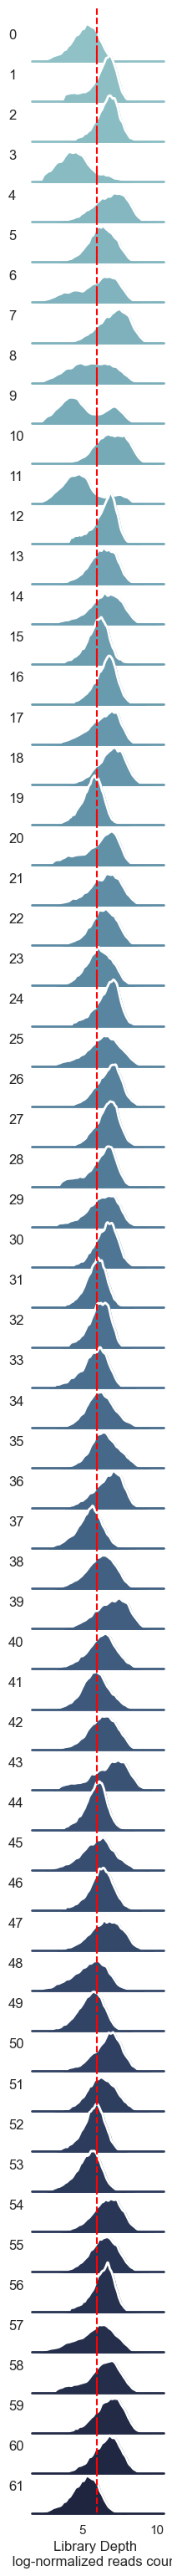

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define palette
pal = sns.cubehelix_palette(len(unique_batches_numpy), rot=-.25, light=.7)

# Initialize FacetGrid
g = sns.FacetGrid(sorted_df, row="batch", hue="batch", aspect=5, height=.5, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "log1p_total_counts", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "log1p_total_counts", clip_on=False, color="w", lw=2, bw_adjust=.5)


def add_mean_line(**kwargs):
    mean_value = np.round(np.mean(sorted_df['log1p_total_counts'].values),0)
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5)

g.map(add_mean_line)
# Add a reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Limit the x-axis
#g.set(xlim=(0, 2000))

g.set_titles("")

# Change x-axis label
g.set_axis_labels("Library Depth \n log-normalized reads counts", None)

# Properly align batch labels on the y-axis
for ax, label in zip(g.axes.flat, unique_batches_numpy):
    ax.set_ylabel(f"{label}", rotation=0, ha='left', va='center', labelpad=20)

# Remove unnecessary plot details
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Show plot
plt.show()


In [29]:
rsc.pp.pca(adata_concat, n_comps=30,random_state=1337, use_highly_variable=False)

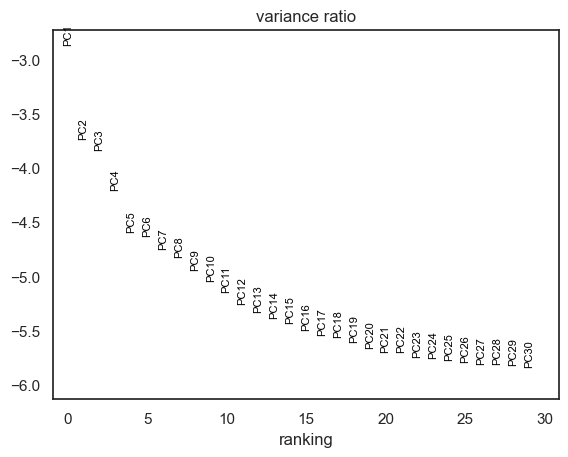

In [31]:
sc.pl.pca_variance_ratio(adata_concat, log=True, n_pcs=30)

In [33]:
rsc.pp.neighbors(adata_concat, n_pcs=15, use_rep='X_pca', n_neighbors=30)

In [41]:
from tqdm import tqdm 
res = np.linspace(0,2,10)
clust_num = []
for r in tqdm(res):
    rsc.tl.leiden(adata_concat, random_state=1337, resolution=r, key_added='cluster')
    clust_num.append(len(pd.unique(adata_concat.obs['cluster']))) 

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.94s/it]


In [44]:
pd.DataFrame({'resolution':res,'k_num':clust_num}).T

,0,1,2,3,4,5,6,7,8,9
resolution,0.0,0.222222,0.444444,0.666667,0.888889,1.111111,1.333333,1.555556,1.777778,2.0
k_num,1.0,8.000000,13.000000,15.000000,24.000000,24.000000,27.000000,35.000000,37.000000,40.0


In [45]:
rsc.tl.leiden(adata_concat, random_state=1337, resolution=0.667, key_added='cluster')

In [46]:
andata_save = adata_concat.copy()

In [47]:
andata_save.write_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_leiden.h5ad"))